# TTT4185 Machine learning for Speech technology

## Computer assignment 2: Classification using the Bayes Decision Rule and Support Vector Machines

This assignment assumes that the student has knowledge about the Bayes Decision Rule, maximum likelihood estimation and support vector machines.

In this assignment we will use `scikit-learn` (http://scikit-learn.org/stable/), which is a powerful and very popular Python toolkit for data analysis and machine learning, and `pandas` (https://pandas.pydata.org), which implements the all-powerful `DataFrame`.

In this assigment we will be using a small database of phonemes, where each phoneme is represented by the four first formant positions ("F1"-"F4") and their corresponding bandwidths ("B1"-"B4"). All numbers are in kHz. In addition the speaker ID and the gender of the speaker are given for each phoneme.

### Problem 1

In this problem we will use the Bayes decision rule to classify vowels based on their formants. The formants have been extracted from the open database `VTR Formants database` (http://www.seas.ucla.edu/spapl/VTRFormants.html) created by Microsoft and UCLA.

(a) Download the files `Train.csv` and `Test.csv` from Blackboard, and load them into a `pandas` dataframe using the command `pd.read_csv`. Using the training data, create a single scatter plot of "F1" vs "F2" for the three vowels
- "ae" as in "bat"
- "ey" as in "bait"
- "ux" as in "boot"

Just eyeing the plots, discuss which classes will be hardest to classify correctly.

<IPython.core.display.Javascript object>


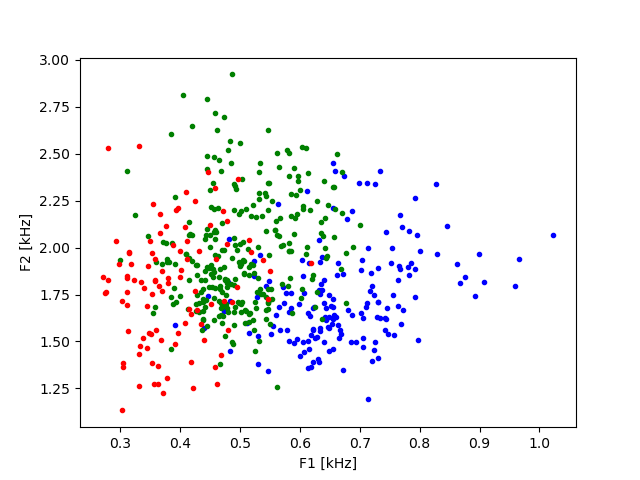

Looking at the plots, it seems like the ey will be the hardest to classify correctly as it overlaps with both ae and ux.


In [224]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix

%matplotlib notebook

# Load data
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

# Extract vowels
aes = train[train["Phoneme"] == 'ae']
eys = train[train["Phoneme"] == 'ey']
uxs = train[train["Phoneme"] == 'ux']

# Plotting here
plt.xlabel("F1 [kHz]")
plt.ylabel("F2 [kHz]")
plt.scatter(aes["F1"],aes["F2"],color="blue",marker='.')
plt.scatter(eys["F1"],eys["F2"],color="green",marker='.')
plt.scatter(uxs["F1"],uxs["F2"],color="red",marker='.')


print("Looking at the plots, it seems like the ey will be the hardest to classify correctly as it overlaps with both ae and ux.")

(b) Use the Bayes Decision Rule to create a classifier for the phonemes 'ae', 'ey' and 'ux' under the following constraints:
- The feature vector $x$ contains the first two formants, "F1" and "F2".
- The distribution of $x$ given a phoneme $c$, $P(x|c)$, is Gaussian.
- Use the maximum likelihood estimator to estimate the model parameters.

Test your classifier on the 'ae', 'ey' and 'ux' phonemes from the test set and present your results in a _confusion matrix_, that is, a table where you see how many times 'ae' was correctly classified, how many times it was wrongly classified as 'ey' and so on.

In [225]:
#Defining the train data for the phonems, this is the training data
columns = [3,4] #The columns that contain the wanted formants, in this case F1 and F2
train_ae = aes[aes.columns[columns]]
train_ey= eys[aes.columns[columns]]
train_ux = uxs[aes.columns[columns]]

train = np.vstack((train_ae, train_ey, train_ux)) #Comibning the train data into one train set

#Defining the test data
test = pd.read_csv("Test.csv")

test_aes = test[test["Phoneme"] == 'ae']
test_eys = test[test["Phoneme"] == 'ey']
test_uxs = test[test["Phoneme"] == 'ux']

#This is the test data with the wanted formants
test_ae = test_aes[test_aes.columns[columns]]
test_ey = test_eys[test_eys.columns[columns]]
test_ux = test_uxs[test_uxs.columns[columns]]


test = np.vstack((test_ae, test_ey, test_ux)) #Comibning the data into one test set

#Correct answers for the train data
target_ae_train = aes[aes.columns[2]]
target_ey_train = eys[eys.columns[2]]
target_ux_train = uxs[uxs.columns[2]]

target_train = pd.concat([target_ae_train, target_ey_train, target_ux_train]) #Comibning the train targets into one set
target_train = target_train.tolist() #Changing the train targets into a list


#Correct answers for the test data
target_ae_test = test_aes[test_aes.columns[2]]
target_ey_test = test_eys[test_eys.columns[2]]
target_ux_test = test_uxs[test_uxs.columns[2]]

target_test = pd.concat([target_ae_test, target_ey_test, target_ux_test]) #Comibning the test targets into one set
target_test = target_test.tolist() #Changing the test targets into a list



#pdf of a given phoneme is gaussian
#The MLE of a gaussian distribution is the mean 
#Extracting the mean for each phoneme in the train data
mean_ae = train_ae.mean(axis=0)
mean_ey = train_ey.mean(axis=0)
mean_ux = train_ux.mean(axis=0)


# Finding the covariance matrixes for wach Phoneme
cov_ae = train_ae.cov()
cov_ey = train_ey.cov()
cov_ux = train_ux.cov()

#Finding the Prior of each phoneme
prior_ae = len(train_ae)/(len(train_ae)+len(train_ey)+len(train_ux))
prior_ey = len(train_ey)/(len(train_ae)+len(train_ey)+len(train_ux))
prior_ux = len(train_ux)/(len(train_ae)+len(train_ey)+len(train_ux))

#Defining the Gaussian distributions
pdf_ae = multivariate_normal(mean = mean_ae, cov = cov_ae)
pdf_ey = multivariate_normal(mean = mean_ey, cov = cov_ey)
pdf_ux = multivariate_normal(mean = mean_ux, cov = cov_ux)



#Using the Bayes desicion rule to make predictions for the train data

sum_train = pdf_ae.pdf(train)*prior_ae + pdf_ey.pdf(train)*prior_ey + pdf_ux.pdf(train)*prior_ux

probability_ae_train = pdf_ae.pdf(train)*prior_ae/sum_train #probability of ae for the train set
probability_ey_train = pdf_ey.pdf(train)*prior_ey/sum_train #probability of ey for the train set
probability_ux_train = pdf_ux.pdf(train)*prior_ux/sum_train #probability of ux for the train set



predictions_train = [0]*(len(probability_ae_train))
for i in range(0, len(probability_ae_train)):
    if probability_ae_train[i] > probability_ey_train[i]:
        if probability_ae_train[i] > probability_ux_train[i]:
            predictions_train[i] = 'ae'
        else:
            predictions_train[i] = 'ux'
            
    else: 
        if probability_ey_train[i] > probability_ux_train[i]:
            predictions_train[i] = 'ey'
        else:
            predictions_train[i] = 'ux'



conf_train=confusion_matrix(target_train,predictions_train)
print(conf_train)
error_train=conf_train[0,1]+conf_train[0,2]+conf_train[1,0]+conf_train[1,2]+conf_train[2,0]+conf_train[2,1]

        
print("Number of errors for the training set:",error_train)        
print("Error rate for training:",error_train/len(predictions_train))
print()





#Using the Bayes desicion rule to make predictions for the test data

sum_test = pdf_ae.pdf(test)*prior_ae + pdf_ey.pdf(test)*prior_ey + pdf_ux.pdf(test)*prior_ux

probability_ae_test = pdf_ae.pdf(test)*prior_ae/sum_test # probability of ae for the test set
probability_ey_test = pdf_ey.pdf(test)*prior_ey/sum_test # probability of ey for the test set
probability_ux_test = pdf_ux.pdf(test)*prior_ux/sum_test # probability of ux for the test set



predictions_test = [0]*(len(probability_ae_test))
for i in range(0, len(probability_ae_test)):
    if probability_ae_test[i] > probability_ey_test[i]:
        if probability_ae_test[i] > probability_ux_test[i]:
            predictions_test[i] = 'ae'
        else:
            predictions_test[i] = 'ux'
            
    else: 
        if probability_ey_test[i] > probability_ux_test[i]:
            predictions_test[i] = 'ey'
        else:
            predictions_test[i] = 'ux'

    
conf_test=confusion_matrix(target_test,predictions_test)
print(conf_test)
error_test=conf_test[0,1]+conf_test[0,2]+conf_test[1,0]+conf_test[1,2]+conf_test[2,0]+conf_test[2,1]

        
print("Number of errors for the test set:",error_test)        
print("Error rate for the test set:",error_test/len(predictions_test))




[[142  30   1]
 [ 19 244  20]
 [  1  39  60]]
Number of errors for the training set: 110
Error rate for training: 0.19784172661870503

[[80 24  1]
 [13 97  4]
 [ 1 28 23]]
Number of errors for the test set: 71
Error rate for the test set: 0.26199261992619927


*Try:* To visualize the classes models and the classifier created in (b), you can:

- Plot the contours for each Gaussian distribution in the model, that is the class conditional likelihoods $P(x|c)$.
- Plot the decision regions for the Bayesian classifier.

<IPython.core.display.Javascript object>


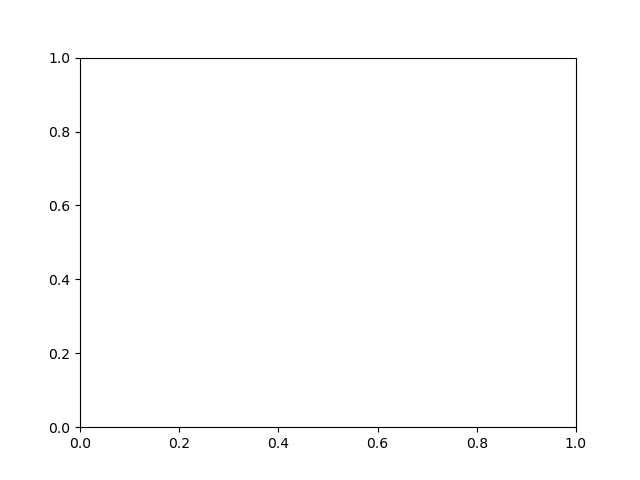

ValueError: operands could not be broadcast together with shapes (60,150,2) (8,) 

In [228]:
#Plot contours for each pdf
x1, y1 = np.mgrid[.4:1:.01, 1:2.5:.01]
pos = np.dstack((x1, y1))
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x1, y1, pdf_train_ae.pdf(pos))

x2, y2 = np.mgrid[.3:.7:.01, 1.4:3:.01]
pos = np.dstack((x2, y2))
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.contourf(x2, y2, pdf_train_ey.pdf(pos))

x3, y3 = np.mgrid[0:.7:.01, 1:3:.01]
pos = np.dstack((x3, y3))
fig4 = plt.figure()
ax4 = fig4.add_subplot(111)
ax4.contourf(x3, y3, pdf_train_ux.pdf(pos))


(c) Extend your classifier to include the features "F1"-"F4" and compare the results with those in (b). Finally use all available information "F1"-"F4" and "B1-B4". How does the performance of this classifier compare with the simpler classifiers using fewer features?

In [229]:
for i in range(0,2):
    if i==0:
        columns = [3,4,5,6] #The columns that contain the wanted formants, in this case F1-F4
        print("Using F1-F4:")
        print()
    if i==1:
        columns = [3,4,5,6,7,8,9,10] #The columns that contain the wanted formants, in this case F1-F4 and B1-B4
        print()
        print()
        print("Using F1-F4 and B1-B4:")
        print()
    #Defining the train data for the phonems, this is the training data
    
    train_ae = aes[aes.columns[columns]]
    train_ey= eys[aes.columns[columns]]
    train_ux = uxs[aes.columns[columns]]
    
    train = np.vstack((train_ae, train_ey, train_ux)) #Comibning the train data into one train set


    #Defining the test data
    test = pd.read_csv("Test.csv")

    test_aes = test[test["Phoneme"] == 'ae']
    test_eys = test[test["Phoneme"] == 'ey']
    test_uxs = test[test["Phoneme"] == 'ux']

    #This is the test data with the wanted formants
    test_ae = test_aes[test_aes.columns[columns]]
    test_ey = test_eys[test_eys.columns[columns]]
    test_ux = test_uxs[test_uxs.columns[columns]]


    test = np.vstack((test_ae, test_ey, test_ux)) #Comibning the data into one test set

    #Correct answers for the train data
    target_ae_train = aes[aes.columns[2]]
    target_ey_train = eys[eys.columns[2]]
    target_ux_train = uxs[uxs.columns[2]]

    target_train = pd.concat([target_ae_train, target_ey_train, target_ux_train]) #Comibning the train targets into one set
    target_train = target_train.tolist() #Changing the train targets into a list
 

    #Correct answers for the test data
    target_ae_test = test_aes[test_aes.columns[2]]
    target_ey_test = test_eys[test_eys.columns[2]]
    target_ux_test = test_uxs[test_uxs.columns[2]]

    target_test = pd.concat([target_ae_test, target_ey_test, target_ux_test]) #Comibning the test targets into one set
    target_test = target_test.tolist() #Changing the test targets into a list



    #pdf of a given phoneme is gaussian
    #The MLE of a gaussian distribution is the mean 
    #Extracting the mean for each phoneme in the train data
    mean_ae = train_ae.mean(axis=0)
    mean_ey = train_ey.mean(axis=0)
    mean_ux = train_ux.mean(axis=0)


    # Finding the covariance matrixes
    cov_ae = train_ae.cov()
    cov_ey = train_ey.cov()
    cov_ux = train_ux.cov()

    #Finding the Prior of each phoneme
    prior_ae = len(train_ae)/(len(train_ae)+len(train_ey)+len(train_ux))
    prior_ey = len(train_ey)/(len(train_ae)+len(train_ey)+len(train_ux))
    prior_ux = len(train_ux)/(len(train_ae)+len(train_ey)+len(train_ux))

    #Defining the Gaussian distributions
    pdf_ae = multivariate_normal(mean = mean_ae, cov = cov_ae)
    pdf_ey = multivariate_normal(mean = mean_ey, cov = cov_ey)
    pdf_ux = multivariate_normal(mean = mean_ux, cov = cov_ux)



    #Using the Bayes desicion rule to make predictions for the train data

    sum_train = pdf_ae.pdf(train)*prior_ae + pdf_ey.pdf(train)*prior_ey + pdf_ux.pdf(train)*prior_ux

    probability_ae_train = pdf_ae.pdf(train)*prior_ae/sum_train #probability of ae for the train set
    probability_ey_train = pdf_ey.pdf(train)*prior_ey/sum_train #probability of ey for the train set
    probability_ux_train = pdf_ux.pdf(train)*prior_ux/sum_train #probability of ux for the train set



    predictions_train = [0]*(len(probability_ae_train))
    for i in range(0, len(probability_ae_train)):
        if probability_ae_train[i] > probability_ey_train[i]:
            if probability_ae_train[i] > probability_ux_train[i]:
                predictions_train[i] = 'ae'
            else:
                predictions_train[i] = 'ux'
            
        else: 
            if probability_ey_train[i] > probability_ux_train[i]:
                predictions_train[i] = 'ey'
            else:
                predictions_train[i] = 'ux'



    conf_train=confusion_matrix(target_train,predictions_train)
    print(conf_train)
    error_train=conf_train[0,1]+conf_train[0,2]+conf_train[1,0]+conf_train[1,2]+conf_train[2,0]+conf_train[2,1]

        
    print("Number of errors for the training set:",error_train)        
    print("Error rate for training:",error_train/len(predictions_train))
    print()



    #Using the Bayes desicion rule to make predictions for the test data

    sum_test = pdf_ae.pdf(test)*prior_ae + pdf_ey.pdf(test)*prior_ey + pdf_ux.pdf(test)*prior_ux

    probability_ae_test = pdf_ae.pdf(test)*prior_ae/sum_test # probability of ae for the test set
    probability_ey_test = pdf_ey.pdf(test)*prior_ey/sum_test # probability of ey for the test set
    probability_ux_test = pdf_ux.pdf(test)*prior_ux/sum_test # probability of ux for the test set



    predictions_test = [0]*(len(probability_ae_test))
    for i in range(0, len(probability_ae_test)):
        if probability_ae_test[i] > probability_ey_test[i]:
            if probability_ae_test[i] > probability_ux_test[i]:
                predictions_test[i] = 'ae'
            else:
                predictions_test[i] = 'ux'
            
        else: 
            if probability_ey_test[i] > probability_ux_test[i]:
                predictions_test[i] = 'ey'
            else:
                predictions_test[i] = 'ux'

    conf_test=confusion_matrix(target_test,predictions_test)
    print(conf_test)
    error_test=conf_test[0,1]+conf_test[0,2]+conf_test[1,0]+conf_test[1,2]+conf_test[2,0]+conf_test[2,1]

        
    print("Number of errors for the test set:",error_test)        
    print("Error rate for the test set:",error_test/len(predictions_test))


print()
print("We can see that when we increase the number of features the performance gets better for the train set but not necessarily better for the test set. Using more features might result in a bit of overfitting. It is better to find the features that most distinctivly seperate the classes and use those.")


Using F1-F4:

[[141  31   1]
 [ 24 246  13]
 [  0  35  65]]
Number of errors for the training set: 104
Error rate for training: 0.18705035971223022

[[82 21  2]
 [13 98  3]
 [ 2 25 25]]
Number of errors for the test set: 66
Error rate for the test set: 0.24354243542435425


Using F1-F4 and B1-B4:

[[149  23   1]
 [ 24 244  15]
 [  0  30  70]]
Number of errors for the training set: 93
Error rate for training: 0.1672661870503597

[[82 23  0]
 [13 90 11]
 [ 3 28 21]]
Number of errors for the test set: 78
Error rate for the test set: 0.2878228782287823

We can see that when we increase the number of features the performance gets better for the train set but not necessarily better for the test set. Using more features might result in a bit of overfitting. It is better to find the features that most distinctivly seperate the classes and use those.


(d) We want to make the model slightly more powerful by modeling the feature vector conditional on both the vowel and gender of speaker, that is $P(x|g,c)$, where $g$ is the gender of the speaker and $c$ is the phoneme label. Show how these models can be used for phoneme classification using marginalization over the gender.

Assume that $P(x|g,c)$ is a multivariate Gaussian and compute the maximum likelihood estimates for the models. Compare the result on the test set with the results in (c).

In [233]:
#Extracting the data based on phoneme and gender
ae_f = aes[aes["Gender"] == 'F']
ae_m = aes[aes["Gender"] == 'M']
ey_f = eys[eys["Gender"] == 'F']
ey_m = eys[eys["Gender"] == 'M']
ux_f = uxs[uxs["Gender"] == 'F']
ux_m = uxs[uxs["Gender"] == 'M']

#Finding the P(gender/phenome)
p_ae_f=len(ae_f)/(len(ae_f)+len(ae_m))
p_ae_m=len(ae_m)/(len(ae_f)+len(ae_m))

p_ey_f=len(ey_f)/(len(ey_f)+len(ey_m))
p_ey_m=len(ey_m)/(len(ey_f)+len(ey_m))

p_ux_f=len(ux_f)/(len(ux_f)+len(ux_m))
p_ux_m=len(ux_m)/(len(ux_f)+len(ux_m))

#Extracting the data with the wanted formants, in this case F1-F4 and B1-B4
columns = [3,4,5,6,7,8,9,10]

#Defining the train data for the phonems, this is the training data
train_ae = aes[aes.columns[columns]]
train_ey= eys[aes.columns[columns]]
train_ux = uxs[aes.columns[columns]]

train = np.vstack((train_ae, train_ey, train_ux)) #Comibning the train data into one train set

#Defining the test data
test = pd.read_csv("Test.csv")

test_aes = test[test["Phoneme"] == 'ae']
test_eys = test[test["Phoneme"] == 'ey']
test_uxs = test[test["Phoneme"] == 'ux']

#This is the test data with the wanted formants
test_ae = test_aes[test_aes.columns[columns]]
test_ey = test_eys[test_eys.columns[columns]]
test_ux = test_uxs[test_uxs.columns[columns]]


test = np.vstack((test_ae, test_ey, test_ux)) #Comibning the data into one test set

ae_f = ae_f[ae_f.columns[columns]]
ae_m = ae_m[ae_m.columns[columns]]
ey_f = ey_f[ey_f.columns[columns]]
ey_m = ey_m[ey_m.columns[columns]]
ux_f = ux_f[ux_f.columns[columns]]
ux_m = ux_m[ux_m.columns[columns]]

#calculating the means
mean_ae_f = ae_f.mean(axis = 0)
mean_ae_m = ae_m.mean(axis = 0)
mean_ey_f = ey_f.mean(axis = 0)
mean_ey_m = ey_m.mean(axis = 0)
mean_ux_f = ux_f.mean(axis = 0)
mean_ux_m = ux_m.mean(axis = 0)

#Getting the covariance matrixes
cov_ae_f = ae_f.cov()
cov_ae_m = ae_m.cov()
cov_ey_f = ey_f.cov()
cov_ey_m = ey_m.cov()
cov_ux_f = ux_f.cov()
cov_ux_m = ux_m.cov()

#P(x|g,c)
pdf_ae_f = multivariate_normal(mean = mean_ae_f, cov = cov_ae_f)
pdf_ae_m = multivariate_normal(mean = mean_ae_m, cov = cov_ae_m)
pdf_ey_f = multivariate_normal(mean = mean_ey_f, cov = cov_ey_f)
pdf_ey_m = multivariate_normal(mean = mean_ey_m, cov = cov_ey_m)
pdf_ux_f = multivariate_normal(mean = mean_ux_f, cov = cov_ux_f)
pdf_ux_m = multivariate_normal(mean = mean_ux_m, cov = cov_ux_m)

#Using the Bayes desicion rule to make predictions for the train data

sum_train = (p_ae_f*pdf_ae_f.pdf(train)+p_ae_m*pdf_ae_m.pdf(train))*prior_ae + (p_ey_f*pdf_ey_f.pdf(train)+p_ey_m*pdf_ey_m.pdf(train))*prior_ey + (p_ux_f*pdf_ux_f.pdf(train)+p_ux_m*pdf_ux_m.pdf(train))*prior_ux

probability_ae_train = (p_ae_f*pdf_ae_f.pdf(train) + p_ae_m*pdf_ae_m.pdf(train))*prior_ae/sum_train #probability of ae for the train set
probability_ey_train = (p_ey_f*pdf_ey_f.pdf(train) + p_ey_m*pdf_ey_m.pdf(train))*prior_ey/sum_train #probability of ey for the train set
probability_ux_train = (p_ux_f*pdf_ux_f.pdf(train) + p_ux_m*pdf_ux_m.pdf(train))*prior_ux/sum_train #probability of ux for the train set



predictions_train = [0]*(len(probability_ae_train))
for i in range(0, len(probability_ae_train)):
    if probability_ae_train[i] > probability_ey_train[i]:
        if probability_ae_train[i] > probability_ux_train[i]:
            predictions_train[i] = 'ae'
        else:
             predictions_train[i] = 'ux'
            
    else: 
        if probability_ey_train[i] > probability_ux_train[i]:
            predictions_train[i] = 'ey'
        else:
            predictions_train[i] = 'ux'



conf_train=confusion_matrix(target_train,predictions_train)
print(conf_train)
error_train=conf_train[0,1]+conf_train[0,2]+conf_train[1,0]+conf_train[1,2]+conf_train[2,0]+conf_train[2,1]

        
print("Number of errors for the training set:",error_train)        
print("Error rate for training:",error_train/len(predictions_train))
print()



#Using the Bayes desicion rule to make predictions for the test data

sum_test = (p_ae_f*pdf_ae_f.pdf(test)+p_ae_m*pdf_ae_m.pdf(test))*prior_ae + (p_ey_f*pdf_ey_f.pdf(test)+p_ey_m*pdf_ey_m.pdf(test))*prior_ey + (p_ux_f*pdf_ux_f.pdf(test)+p_ux_m*pdf_ux_m.pdf(test))*prior_ux

probability_ae_test = (p_ae_f*pdf_ae_f.pdf(test) + p_ae_m*pdf_ae_m.pdf(test))*prior_ae/sum_test #probability of ae for the train set
probability_ey_test = (p_ey_f*pdf_ey_f.pdf(test) + p_ey_m*pdf_ey_m.pdf(test))*prior_ey/sum_test #probability of ey for the train set
probability_ux_test = (p_ux_f*pdf_ux_f.pdf(test) + p_ux_m*pdf_ux_m.pdf(test))*prior_ux/sum_test #probability of ux for the train set


predictions_test = [0]*(len(probability_ae_test))
for i in range(0, len(probability_ae_test)):
    if probability_ae_test[i] > probability_ey_test[i]:
        if probability_ae_test[i] > probability_ux_test[i]:
            predictions_test[i] = 'ae'
        else:
            predictions_test[i] = 'ux'
            
    else: 
        if probability_ey_test[i] > probability_ux_test[i]:
            predictions_test[i] = 'ey'
        else:
            predictions_test[i] = 'ux'

conf_test=confusion_matrix(target_test,predictions_test)
print(conf_test)
error_test=conf_test[0,1]+conf_test[0,2]+conf_test[1,0]+conf_test[1,2]+conf_test[2,0]+conf_test[2,1]

        
print("Number of errors for the test set:",error_test)        
print("Error rate for the test set:",error_test/len(predictions_test))


print()
print("The performance when using all the features is better when we also separate the genders than it was in C). But it is not much better. We can also see that when using this many features the model does not generalize well.")




[[147  25   1]
 [ 23 246  14]
 [  1  22  77]]
Number of errors for the training set: 86
Error rate for training: 0.15467625899280577

[[84 21  0]
 [15 89 10]
 [ 4 24 24]]
Number of errors for the test set: 74
Error rate for the test set: 0.2730627306273063

The performance when using all the features is better when we also separate the genders than it was in C). But it is not much better. We can also see that when using this many features the model does not generalize well.


(e) When using Gaussian classifiers we often avoid computing the entire covariance matrix, but instead we only use the diagonal of the matrix. Repeat the results in (d) using only diagonal covariance matrices and compare the results.

In [235]:
#Getting the covariance matrixes
cov_ae_f = ae_f.cov()
cov_ae_m = ae_m.cov()
cov_ey_f = ey_f.cov()
cov_ey_m = ey_m.cov()
cov_ux_f = ux_f.cov()
cov_ux_m = ux_m.cov()

#Making all the covariance matrices diagonal
cov_ae_f = np.diag(np.diag(cov_ae_f))
cov_ae_m = np.diag(np.diag(cov_ae_m))
cov_ey_f = np.diag(np.diag(cov_ey_f))
cov_ey_m = np.diag(np.diag(cov_ey_m))
cov_ux_f = np.diag(np.diag(cov_ux_f))
cov_ux_m = np.diag(np.diag(cov_ux_m))



#P(x|g,c)
pdf_ae_f = multivariate_normal(mean = mean_ae_f, cov = cov_ae_f)
pdf_ae_m = multivariate_normal(mean = mean_ae_m, cov = cov_ae_m)
pdf_ey_f = multivariate_normal(mean = mean_ey_f, cov = cov_ey_f)
pdf_ey_m = multivariate_normal(mean = mean_ey_m, cov = cov_ey_m)
pdf_ux_f = multivariate_normal(mean = mean_ux_f, cov = cov_ux_f)
pdf_ux_m = multivariate_normal(mean = mean_ux_m, cov = cov_ux_m)

#Using the Bayes desicion rule to make predictions for the train data

sum_train = (p_ae_f*pdf_ae_f.pdf(train)+p_ae_m*pdf_ae_m.pdf(train))*prior_ae + (p_ey_f*pdf_ey_f.pdf(train)+p_ey_m*pdf_ey_m.pdf(train))*prior_ey + (p_ux_f*pdf_ux_f.pdf(train)+p_ux_m*pdf_ux_m.pdf(train))*prior_ux

probability_ae_train = (p_ae_f*pdf_ae_f.pdf(train) + p_ae_m*pdf_ae_m.pdf(train))*prior_ae/sum_train #probability of ae for the train set
probability_ey_train = (p_ey_f*pdf_ey_f.pdf(train) + p_ey_m*pdf_ey_m.pdf(train))*prior_ey/sum_train #probability of ey for the train set
probability_ux_train = (p_ux_f*pdf_ux_f.pdf(train) + p_ux_m*pdf_ux_m.pdf(train))*prior_ux/sum_train #probability of ux for the train set



predictions_train = [0]*(len(probability_ae_train))
for i in range(0, len(probability_ae_train)):
    if probability_ae_train[i] > probability_ey_train[i]:
        if probability_ae_train[i] > probability_ux_train[i]:
            predictions_train[i] = 'ae'
        else:
             predictions_train[i] = 'ux'
            
    else: 
        if probability_ey_train[i] > probability_ux_train[i]:
            predictions_train[i] = 'ey'
        else:
            predictions_train[i] = 'ux'



conf_train=confusion_matrix(target_train,predictions_train)
print(conf_train)
error_train=conf_train[0,1]+conf_train[0,2]+conf_train[1,0]+conf_train[1,2]+conf_train[2,0]+conf_train[2,1]

        
print("Number of errors for the training set:",error_train)        
print("Error rate for training:",error_train/len(predictions_train))
print()



#Using the Bayes desicion rule to make predictions for the test data

sum_test = (p_ae_f*pdf_ae_f.pdf(test)+p_ae_m*pdf_ae_m.pdf(test))*prior_ae + (p_ey_f*pdf_ey_f.pdf(test)+p_ey_m*pdf_ey_m.pdf(test))*prior_ey + (p_ux_f*pdf_ux_f.pdf(test)+p_ux_m*pdf_ux_m.pdf(test))*prior_ux

probability_ae_test = (p_ae_f*pdf_ae_f.pdf(test) + p_ae_m*pdf_ae_m.pdf(test))*prior_ae/sum_test #probability of ae for the train set
probability_ey_test = (p_ey_f*pdf_ey_f.pdf(test) + p_ey_m*pdf_ey_m.pdf(test))*prior_ey/sum_test #probability of ey for the train set
probability_ux_test = (p_ux_f*pdf_ux_f.pdf(test) + p_ux_m*pdf_ux_m.pdf(test))*prior_ux/sum_test #probability of ux for the train set


predictions_test = [0]*(len(probability_ae_test))
for i in range(0, len(probability_ae_test)):
    if probability_ae_test[i] > probability_ey_test[i]:
        if probability_ae_test[i] > probability_ux_test[i]:
            predictions_test[i] = 'ae'
        else:
            predictions_test[i] = 'ux'
            
    else: 
        if probability_ey_test[i] > probability_ux_test[i]:
            predictions_test[i] = 'ey'
        else:
            predictions_test[i] = 'ux'

conf_test=confusion_matrix(target_test,predictions_test)
print(conf_test)
error_test=conf_test[0,1]+conf_test[0,2]+conf_test[1,0]+conf_test[1,2]+conf_test[2,0]+conf_test[2,1]

        
print("Number of errors for the test set:",error_test)        
print("Error rate for the test set:",error_test/len(predictions_test))

print()
print("We can see that the performance on the training data is a bit worse, but the performance on the test data is a bit better. ")



[[145  27   1]
 [ 31 230  22]
 [  2  25  73]]
Number of errors for the training set: 108
Error rate for training: 0.19424460431654678

[[86 18  1]
 [18 87  9]
 [ 1 21 30]]
Number of errors for the test set: 68
Error rate for the test set: 0.25092250922509224

We can see that the performance on the training data is a bit worse, but the performance on the test data is a bit better. 


### Problem 2

In this problem we use the support vector machine (SVM) to build classifiers. We use the same dataset as in Problem 1. It is up to you to select which features to use.

We use the function `sklearn.svm.SVC` from `scikit-learn` in this problem. First you need to get your data on the format that `SVC` expects, which is a matrix where every row is a feature vector, and a list of integer labels corresponding to each row. We suggest using "ae" = 0, "ey" = 1 and "ux" = 2.

An example on how to use the `SVC` is given in http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC. In short we do the following (for a linear kernel):
- Instantiate an SVC object: `cls = SVC(kernel='linear')`
- Train the SVM using the feature vector matrix `train_X`, and label vector `train_Y`: `cls.fit(train_X, train_Y)`
- Predict labels on the test set `Test_X` using: `cls.predict(Test_X)`

(a) Create a linear SVM with different penalty terms $C=\{0.1, 1, 10\}$ and compare with the results in Problem 1.

In [212]:
from sklearn.svm import SVC

#Defining the train data for the phonems, this is the training data
columns = [3,4,5,6] #The columns that contain the wanted formants, in this case F1-F4
train_ae = aes[aes.columns[columns]]
train_ey= eys[aes.columns[columns]]
train_ux = uxs[aes.columns[columns]]

train = np.vstack((train_ae, train_ey, train_ux)) #Comibning the train data into one train set

#Defining the test data
test = pd.read_csv("Test.csv")

test_aes = test[test["Phoneme"] == 'ae']
test_eys = test[test["Phoneme"] == 'ey']
test_uxs = test[test["Phoneme"] == 'ux']

#This is the test data with the wanted formants
test_ae = test_aes[test_aes.columns[columns]]
test_ey = test_eys[test_eys.columns[columns]]
test_ux = test_uxs[test_uxs.columns[columns]]


test = np.vstack((test_ae, test_ey, test_ux)) #Comibning the data into one test set

target_train = []
#Correct answers for the train data in the wanted format
for i in range(0,len(train)+1):
    if 0<i<=len(train_ae):
        target_train.append(0)
    if len(train_ae)<i<=len(train_ae)+len(train_ey):
        target_train.append(1)
    if len(train_ae)+len(train_ey)<i<=len(train)+1:
        target_train.append(2)


target_test = []
#Correct answers for the test data in the wanted format
for i in range(0,len(test)+1):
    if 0<i<=len(test_ae):
        target_test.append(0)
    if len(test_ae)<i<=len(test_ae)+len(test_ey):
        target_test.append(1)
    if len(test_ae)+len(test_ey)<i<=len(test)+1:
        target_test.append(2)

#Defining the penalty terms
c_1 = 0.1
c_2 = 1
c_3 = 10

#Instantiate an SVC object for each pealty
cls_1 = SVC(c_1,kernel = "linear")
cls_2 = SVC(c_2,kernel = "linear")
cls_3 = SVC(c_3,kernel = "linear")

#fiting the three models
cls_1 = cls_1.fit(train,target_train)
cls_2 = cls_2.fit(train,target_train)
cls_3 = cls_3.fit(train,target_train)

#Predicting for the train set
predictions_train_1 = cls_1.predict(train)
predictions_train_2 = cls_2.predict(train)
predictions_train_3 = cls_3.predict(train)

#Confusion matrices and error rates for the train set
conf_train_1 = confusion_matrix(predictions_train_1,target_train)
conf_train_2 = confusion_matrix(predictions_train_2,target_train)
conf_train_3 = confusion_matrix(predictions_train_3,target_train)


error_train_1=conf_train_1[0,1]+conf_train_1[0,2]+conf_train_1[1,0]+conf_train_1[1,2]+conf_train_1[2,0]+conf_train_1[2,1]
error_train_2=conf_train_2[0,1]+conf_train_2[0,2]+conf_train_2[1,0]+conf_train_2[1,2]+conf_train_2[2,0]+conf_train_2[2,1]
error_train_3=conf_train_3[0,1]+conf_train_3[0,2]+conf_train_3[1,0]+conf_train_3[1,2]+conf_train_3[2,0]+conf_train_3[2,1]


#Predicting for the test set
predictions_test_1 = cls_1.predict(test)
predictions_test_2 = cls_2.predict(test)
predictions_test_3 = cls_3.predict(test)

#Confusion matrices and error rates for the test set
conf_test_1 = confusion_matrix(predictions_test_1,target_test)
conf_test_2 = confusion_matrix(predictions_test_2,target_test)
conf_test_3 = confusion_matrix(predictions_test_3,target_test)


error_test_1=conf_test_1[0,1]+conf_test_1[0,2]+conf_test_1[1,0]+conf_test_1[1,2]+conf_test_1[2,0]+conf_test_1[2,1]
error_test_2=conf_test_2[0,1]+conf_test_2[0,2]+conf_test_2[1,0]+conf_test_2[1,2]+conf_test_2[2,0]+conf_test_2[2,1]
error_test_3=conf_test_3[0,1]+conf_test_3[0,2]+conf_test_3[1,0]+conf_test_3[1,2]+conf_test_3[2,0]+conf_test_3[2,1]

print("For C=0.1")
print()
print(conf_train_1)
print()      
print("Number of errors for the train set for C=0.1:",error_train_1)        
print("Error rate for the trian set for C=0.1:",error_train_1/len(predictions_train_1))
print()
print(conf_test_1)
print()      
print("Number of errors for the test set for C=0.1:",error_test_1)        
print("Error rate for the test set for C=0.1:",error_test_1/len(predictions_test_1))

print()
print()
print("For C=1")
print()
print(conf_train_2)
print()      
print("Number of errors for the train set for C=1:",error_train_2)        
print("Error rate for the train set for C=1:",error_train_2/len(predictions_train_2))
print()
print(conf_test_2)
print()      
print("Number of errors for the test set for C=1:",error_test_2)        
print("Error rate for the test set for C=1:",error_test_2/len(predictions_test_2))

print()
print()
print("For C=10")
print()
print(conf_train_3)
print()      
print("Number of errors for the train set for C=10:",error_train_3)        
print("Error rate for the train set for C=10:",error_train_3/len(predictions_train_3))
print()
print(conf_test_3)
print()      
print("Number of errors for the test set for C=10:",error_test_3)        
print("Error rate for the test set for C=10:",error_test_3/len(predictions_test_3))

print()
print("We can see that the performance of the SVM is margianally worse when usin C=10 than the model in a) when using F1-F4. For C=0.1 or C=1 it is alot worse.")

For C=0.1

[[ 65   3   3]
 [108 280  97]
 [  0   0   0]]

Number of errors for the train set for C=0.1: 211
Error rate for the trian set for C=0.1: 0.37949640287769787

[[ 34   1   3]
 [ 71 113  49]
 [  0   0   0]]

Number of errors for the test set for C=0.1: 124
Error rate for the test set for C=0.1: 0.4575645756457565


For C=1

[[137  19   1]
 [ 35 263  84]
 [  1   1  15]]

Number of errors for the train set for C=1: 141
Error rate for the train set for C=1: 0.25359712230215825

[[ 78  10   6]
 [ 27 104  41]
 [  0   0   5]]

Number of errors for the test set for C=1: 84
Error rate for the test set for C=1: 0.30996309963099633


For C=10

[[137  20   0]
 [ 35 248  39]
 [  1  15  61]]

Number of errors for the train set for C=10: 110
Error rate for the train set for C=10: 0.19784172661870503

[[ 78  10   3]
 [ 26 102  26]
 [  1   2  23]]

Number of errors for the test set for C=10: 68
Error rate for the test set for C=10: 0.25092250922509224


/Users/torabjerkmo/opt/miniconda3/envs/ttt4185/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass C=0.1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/torabjerkmo/opt/miniconda3/envs/ttt4185/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass C=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/torabjerkmo/opt/miniconda3/envs/ttt4185/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass C=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


(b) Try different kernels ('rbf', 'poly', 'sigmoid') and compare the results. Choose one of the kernels and use different penalty terms $C$. What happens with the performance on the training set when you increase $C$? What happens with the performance on the test set?

In [236]:
cls_rbf = SVC(c_2, kernel = 'rbf') #Using C=1
cls_poly = SVC(c_2, kernel = 'poly')
cls_sigm = SVC(c_2, kernel = 'sigmoid')

#fitting the modesl 
cls_rbf = cls_rbf.fit(train, target_train)
cls_poly = cls_poly.fit(train, target_train)
cls_sigm = cls_sigm.fit(train, target_train)

#predicting for the train set
predictions_train_rbf = cls_rbf.predict(train)
predictions_train_poly = cls_poly.predict(train)
predictions_train_sigm = cls_sigm.predict(train)

conf_train_rbf = confusion_matrix(predictions_train_rbf, target_train)
conf_train_poly = confusion_matrix(predictions_train_poly, target_train)
conf_train_sigm = confusion_matrix(predictions_train_sigm, target_train)

#Confusion matrices and error rates
conf_train_rbf = confusion_matrix(predictions_train_rbf,target_train)
conf_train_poly = confusion_matrix(predictions_train_poly,target_train)
conf_train_sigm = confusion_matrix(predictions_train_sigm,target_train)


error_train_rbf=conf_train_rbf[0,1]+conf_train_rbf[0,2]+conf_train_rbf[1,0]+conf_train_rbf[1,2]+conf_train_rbf[2,0]+conf_train_rbf[2,1]
error_train_poly=conf_train_poly[0,1]+conf_train_poly[0,2]+conf_train_poly[1,0]+conf_train_poly[1,2]+conf_train_poly[2,0]+conf_train_poly[2,1]
error_train_sigm=conf_train_sigm[0,1]+conf_train_sigm[0,2]+conf_train_sigm[1,0]+conf_train_sigm[1,2]+conf_train_sigm[2,0]+conf_train_sigm[2,1]

#predicting for the test set
predictions_test_rbf = cls_rbf.predict(test)
predictions_test_poly = cls_poly.predict(test)
predictions_test_sigm = cls_sigm.predict(test)

conf_test_rbf = confusion_matrix(predictions_test_rbf, target_test)
conf_test_poly = confusion_matrix(predictions_test_poly, target_test)
conf_test_sigm = confusion_matrix(predictions_test_sigm, target_test)

#Confusion matrices and error rates
conf_test_rbf = confusion_matrix(predictions_test_rbf,target_test)
conf_test_poly = confusion_matrix(predictions_test_poly,target_test)
conf_test_sigm = confusion_matrix(predictions_test_sigm,target_test)


error_test_rbf=conf_test_rbf[0,1]+conf_test_rbf[0,2]+conf_test_rbf[1,0]+conf_test_rbf[1,2]+conf_test_rbf[2,0]+conf_test_rbf[2,1]
error_test_poly=conf_test_poly[0,1]+conf_test_poly[0,2]+conf_test_poly[1,0]+conf_test_poly[1,2]+conf_test_poly[2,0]+conf_test_poly[2,1]
error_test_sigm=conf_test_sigm[0,1]+conf_test_sigm[0,2]+conf_test_sigm[1,0]+conf_test_sigm[1,2]+conf_test_sigm[2,0]+conf_test_sigm[2,1]


print("Using rbf:")
print()
print(conf_train_rbf)
print()      
print("Number of errors for the train set using rbf:",error_train_rbf)        
print("Error rate for the trian set using rbf:",error_train_rbf/len(predictions_train_rbf))
print()
print(conf_test_rbf)
print()      
print("Number of errors for the test set using rbf:",error_test_rbf)        
print("Error rate for the test set using rbf:",error_test_rbf/len(predictions_test_rbf))

print()
print()
print("Using poly:")
print()
print(conf_train_poly)
print()      
print("Number of errors for the train set using poly:",error_train_poly)        
print("Error rate for the train set using poly:",error_train_poly/len(predictions_train_poly))
print()
print(conf_test_poly)
print()      
print("Number of errors for the test set using poly:",error_test_poly)        
print("Error rate for the test set using poly:",error_test_poly/len(predictions_test_poly))

print()
print()
print("Using sigmoid")
print()
print(conf_train_sigm)
print()      
print("Number of errors for the train set using sigmoid:",error_train_sigm)        
print("Error rate for the train set using sigmoid:",error_train_sigm/len(predictions_train_sigm))
print()
print(conf_test_sigm)
print()      
print("Number of errors for the test set using sigmoid:",error_test_sigm)        
print("Error rate for the test set using sigmoid",error_test_sigm/len(predictions_test_sigm))

#choosing the poly as it had the best results to see if there is any difference in the confusion matrices for different values of C

cls_poly_1 = SVC(c_1, kernel = 'poly')
cls_poly_3 = SVC(c_3, kernel = 'poly')
cls_poly_1 = cls_poly_1.fit(train, target_train)
cls_poly_3 = cls_poly_3.fit(train, target_train)

#predicing for the train set
predictions_train_poly_1 = cls_poly_1.predict(train)
predictions_train_poly_3 = cls_poly_3.predict(train)

#predicing for the test set
predictions_test_poly_1 = cls_poly_1.predict(test)
predictions_test_poly_3 = cls_poly_3.predict(test)

#Confusion matrices and error rates for the train set
conf_train_poly_1 = confusion_matrix(predictions_train_poly_1,target_train)
conf_train_poly_3 = confusion_matrix(predictions_train_poly_3,target_train)


error_train_poly_1=conf_train_poly_1[0,1]+conf_train_poly_1[0,2]+conf_train_poly_1[1,0]+conf_train_poly_1[1,2]+conf_train_poly_1[2,0]+conf_train_poly_1[2,1]
error_train_poly_3=conf_train_poly_3[0,1]+conf_train_poly_3[0,2]+conf_train_poly_3[1,0]+conf_train_poly_3[1,2]+conf_train_poly_3[2,0]+conf_train_poly_3[2,1]


#Confusion matrices and error rates for the test set
conf_test_poly_1 = confusion_matrix(predictions_test_poly_1,target_test)
conf_test_poly_3 = confusion_matrix(predictions_test_poly_3,target_test)


error_test_poly_1=conf_test_poly_1[0,1]+conf_test_poly_1[0,2]+conf_test_poly_1[1,0]+conf_test_poly_1[1,2]+conf_test_poly_1[2,0]+conf_test_poly_1[2,1]
error_test_poly_3=conf_test_poly_3[0,1]+conf_test_poly_3[0,2]+conf_test_poly_3[1,0]+conf_test_poly_3[1,2]+conf_test_poly_3[2,0]+conf_test_poly_3[2,1]

print()
print()
print("Using poly:")
print("For C=0.1:")
print()
print(conf_train_poly_1)
print()      
print("Number of errors for the train set for C=0.1:",error_train_poly_1)        
print("Error rate for the train set for C=0.1:",error_train_poly_1/len(predictions_train_poly_1))
print()
print(conf_test_poly_1)
print()      
print("Number of errors for the test set for C=0.1:",error_test_poly_1)        
print("Error rate for the test set for C=0.1:",error_test_poly_1/len(predictions_test_poly_1))
print()
print()
print("For C=10:")
print()
print(conf_train_poly_3)
print()      
print("Number of errors for the train set for C=10:",error_train_poly_3)        
print("Error rate for the train set for C=10:",error_train_poly_3/len(predictions_train_poly_3))
print()
print(conf_test_poly_3)
print()      
print("Number of errors for the test set for C=10:",error_test_poly_3)        
print("Error rate for the test set for C=10",error_test_poly_3/len(predictions_test_poly_3))

print()
print("We can see that the performance increases a little bit when using C=10 instead of C=1 for both the train and test set when using poly as the kernel. The performance is much worse when using C=0.1"    )
print("This is the same as we observe when using a linear kernel.")


/Users/torabjerkmo/opt/miniconda3/envs/ttt4185/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass C=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/torabjerkmo/opt/miniconda3/envs/ttt4185/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass C=0.1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/torabjerkmo/opt/miniconda3/envs/ttt4185/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass C=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Using rbf:

[[109   3   5]
 [ 64 280  95]
 [  0   0   0]]

Number of errors for the train set using rbf: 167
Error rate for the trian set using rbf: 0.30035971223021585

[[ 53   3   4]
 [ 52 111  48]
 [  0   0   0]]

Number of errors for the test set using rbf: 107
Error rate for the test set using rbf: 0.3948339483394834


Using poly:

[[137  17   1]
 [ 36 266  97]
 [  0   0   2]]

Number of errors for the train set using poly: 151
Error rate for the train set using poly: 0.2715827338129496

[[ 77   9   5]
 [ 28 105  46]
 [  0   0   1]]

Number of errors for the test set using poly: 88
Error rate for the test set using poly: 0.3247232472324723


Using sigmoid

[[  0   0   1]
 [173 283  99]
 [  0   0   0]]

Number of errors for the train set using sigmoid: 273
Error rate for the train set using sigmoid: 0.4910071942446043

[[  0   0   0]
 [105 114  52]
 [  0   0   0]]

Number of errors for the test set using sigmoid: 157
Error rate for the test set using sigmoid 0.5793357933579336


Us